In [163]:
# -*- coding:utf-8 -*-
import csv
import math
import datetime

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

import cv2
from PIL import Image

%matplotlib inline


In [369]:
file = '7520862'

In [157]:
#CSVファイル読み込みVer01　ヘッダー無しデータ用
csv_name = "./"+file+".csv"
csv_file = open(csv_name, "r")
#csv_file = open("./3453421.csv", "r")
#リスト形式
lines = csv.reader(csv_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
#next(csv.reader(f))

In [374]:
#CSVファイル読み込みVer02　ヘッダー付き
lines = []

csv_name = "./"+file+".csv" # <- dirをつける
try:
    with open(csv_name, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダーを読み飛ばしたい時

        for row in reader:
            lines.append(row)          # 1行づつ取得できる
except FileNotFoundError:
    print('file not found. {}'.format(csv_name))

file not found. ./7520862-.csv


In [328]:
#メソッド

#座標補正メソッド
def corrected_data(line):
    xy_lst = []
    #　小数点以下切り上げ
    line[1] = math.ceil(float(line[1]))
    line[2] = math.ceil(float(line[2]))
    #x軸補正
    if line[1] < 0:
        xy_lst.append(line[1]*(-1) + 90)
    else:
        xy_lst.append((line[1] - 90)*(-1))
     #補正無しX軸   
    #xy_lst.append(line[1])
    
    #y軸補正
    fix_y = line[2] + 180
    if fix_y > 360 :
        xy_lst.append(fix_y - 360)
    else:
        xy_lst.append(fix_y)
    return xy_lst

#余白削除メソッド
def margin_cut(file_name='./hm_7306642.jpg',output_name='./hm_7306642_edge.png'):
    filename = file_name #'./image_3453421.jpg'
    img = cv2.imread(filename)
    img2 = cv2.imread(filename)

    # Grayscale に変換
    img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2 値化
    ret, thresh = cv2.threshold(img_gs, 250, 255, cv2.THRESH_BINARY)

    # 輪郭を取得
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # i = 1 は画像全体の外枠になるのでカウントに入れない
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in range(1, len(contours)):
        # ret の中身は (x, y, w, h)
        ret = cv2.boundingRect(contours[i])
        x1.append(ret[0])
        y1.append(ret[1])
        x2.append(ret[0] + ret[2])
        y2.append(ret[1] + ret[3])

    x1_min = min(x1)
    y1_min = min(y1)
    x2_max = max(x2)
    y2_max = max(y2)

    # 枠取りをした結果を表示
    #cv2.rectangle(img, (x1_min, y1_min), (x2_max, y2_max), (0, 255, 0), 2)
    #cv2.imwrite('cropped_edge_rectangle.jpg', img)

    # ギリギリで切り出し
    crop_img = img2[y1_min:y2_max, x1_min:x2_max]
    cv2.imwrite(output_name, crop_img)


In [329]:
#座標補正処理 Ver02
axis_data_lst = []
f_lst = []
idx = 0
for line in lines:    
    data = corrected_data(line) #座標補正
    axis_data_lst.append(data)

In [230]:
#座標補正処理 Ver01
axis_data_lst = []
f_lst = []
idx = 0
for line in lines:
    xy_lst = []
    f_lst.append(line)
    #line[0] = idx
    #　小数点以下切り上げ
    line[1] = math.ceil(float(line[1]))
    line[2] = math.ceil(float(line[2]))
    #x軸補正
    if line[1] < 0:
        xy_lst.append(line[1]*(-1) + 90)
    else:
        xy_lst.append((line[1] - 90)*(-1))
     #補正無しX軸   
    #xy_lst.append(line[1])
    
    #y軸補正
    fix_y = line[2] + 180
    if fix_y > 360 :
        xy_lst.append(fix_y - 360)
    else:
        xy_lst.append(fix_y)  

    axis_data_lst.append(xy_lst)
    #idx += 1

#5427509データ補正    
#axis_data_lst.append([90,0])

IndentationError: expected an indented block (<ipython-input-230-cdaaeb66d67b>, line 28)

In [205]:
for i,x in zip(range(0,18),range(0,180,10)):
    print(i,x)

0 0
1 10
2 20
3 30
4 40
5 50
6 60
7 70
8 80
9 90
10 100
11 110
12 120
13 130
14 140
15 150
16 160
17 170


In [330]:
#ヒートマップデータ作成Ver02
lst_2d = [] #ヒートマップデータ配列
x_ranges = [] #x軸bin範囲配列
x_cnt = [] #x軸bin配列

#x軸範囲設定
i = 0
for x in range(0,360,18):
    x_cnt.append(i)
    x_ranges.append(x)
    i += 1
    
#x軸データ管理配列設定   
x_length = len(x_cnt)    

#x:yデータ集計
for i in range(0,180,10):
    x_lst = [0] * x_length
    for xy in  axis_data_lst:
        x = xy[0]
        if x >= i and x < i + 10:
            for cnt, x_range in zip(x_cnt, x_ranges):
                if xy[1] >= x_range and xy[1] < x_range + 18:
                        x_lst[cnt] += 1
    lst_2d.append(x_lst) 

In [236]:
#実験　実際のvのレンジ幅
x_min = 1000
x_max = 0
for xs in lst_2d:
    for x in xs:
        if x_max < x:
            x_max = x
        if x_min > x:
            x_min = x
print('max:{}/min:{}'.format(x_max,x_min))

max:96/min:0


In [166]:
'''
#ヒートマップデータ作成Ver01
lst_2d = []
for i in range(0,180,10):
    x_lst = [0] * 10
    for xy in  axis_data_lst:
        x = xy[0]
        if x >= i and x < i + 10:
            if xy[1] >= 0 and xy[1] < 36:
                    x_lst[0] += 1
            elif xy[1] >= 36 and xy[1] < 72:
                    x_lst[1] += 1
            elif xy[1] >= 72 and xy[1] < 108:
                    x_lst[2] += 1
            elif xy[1] >= 108 and xy[1] < 144:   
                    x_lst[3] += 1
            elif xy[1] >= 144 and xy[1] < 180:
                    x_lst[4] += 1
            elif xy[1] >= 180 and xy[1] < 216:
                    x_lst[5] += 1
            elif xy[1] >= 216 and xy[1] < 252:
                    x_lst[6] += 1
            elif xy[1] >= 252 and xy[1] < 288:
                    x_lst[7] += 1
            elif xy[1] >= 288 and xy[1] < 324:
                    x_lst[8] += 1
            elif xy[1] >= 324 and xy[1] <= 360:
                    x_lst[9] += 1
    lst_2d.append(x_lst)
'''    

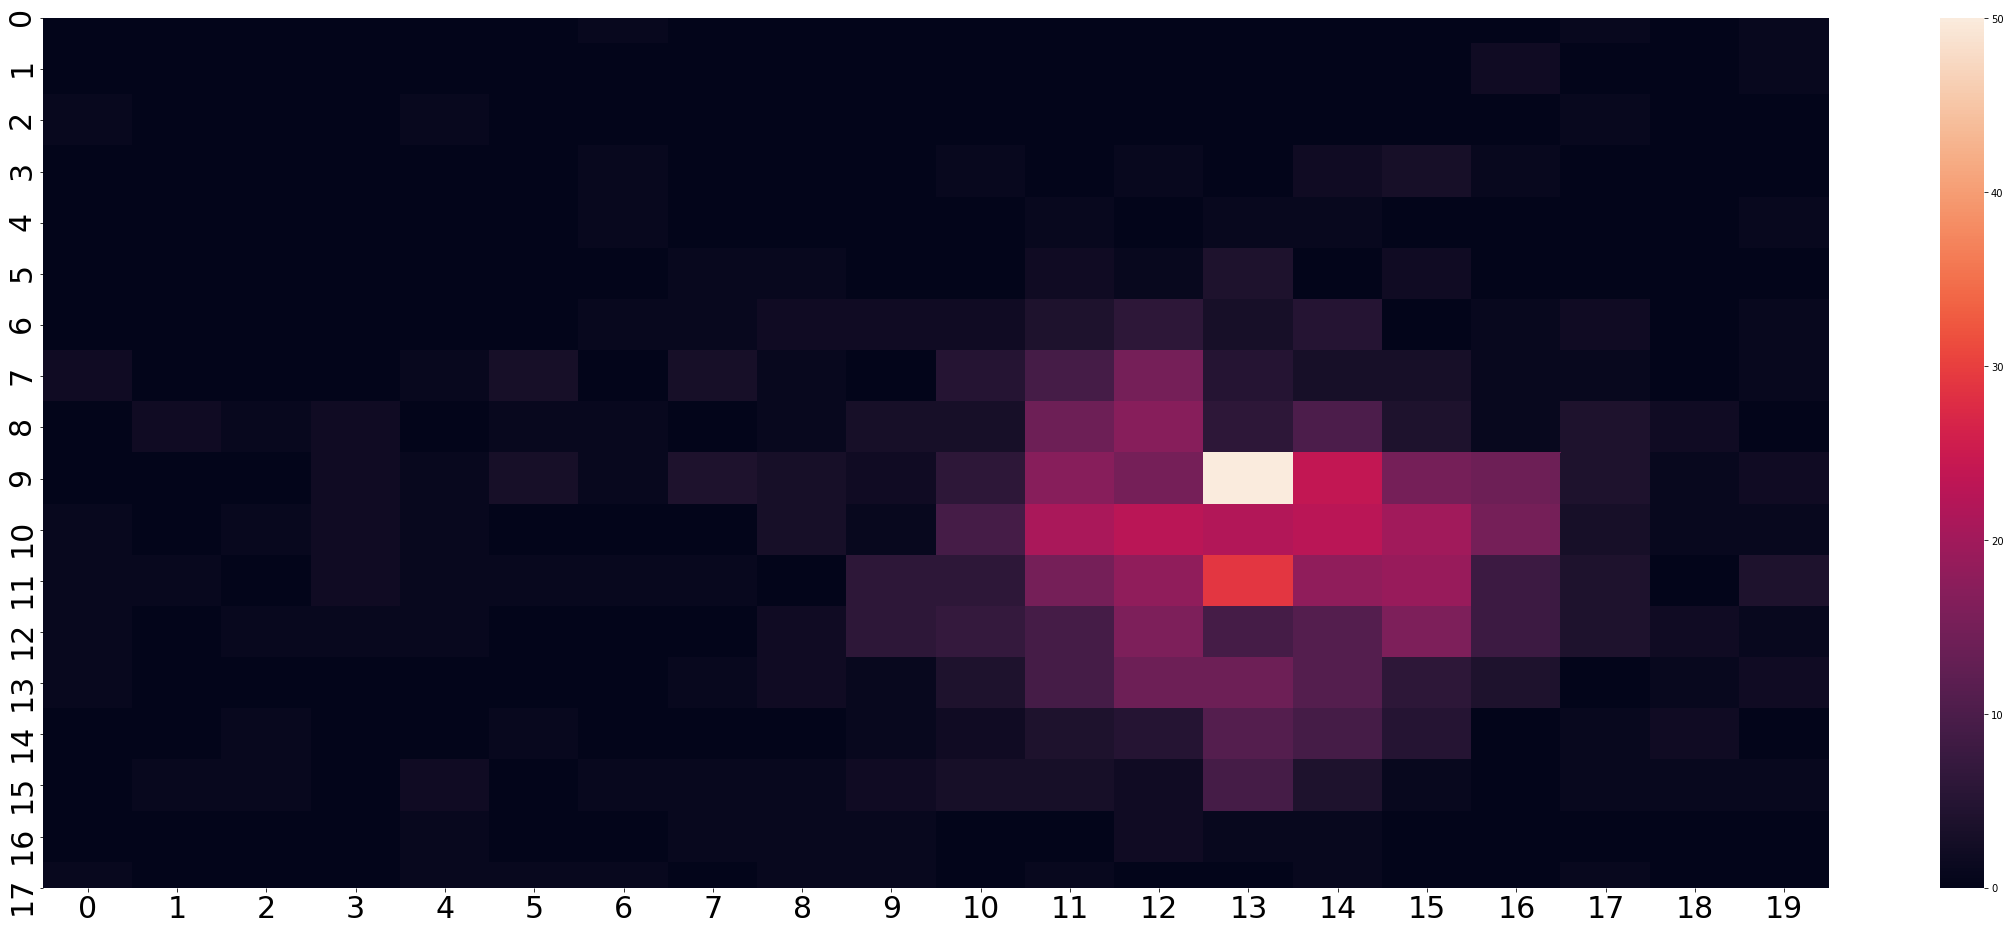

In [331]:
#凡例付きヒートマップ作成
hm_name_sample = "hm_"+file+"_sample.jpg"　#<= dirをつける
plt.figure(figsize=(40,16)) 
#fig, ax = plt.subplots(figsize=(32,16))
plt.tick_params(labelsize=30)
sns.heatmap(lst_2d,vmin=0, vmax=50)
plt.savefig(hm_name_sample )

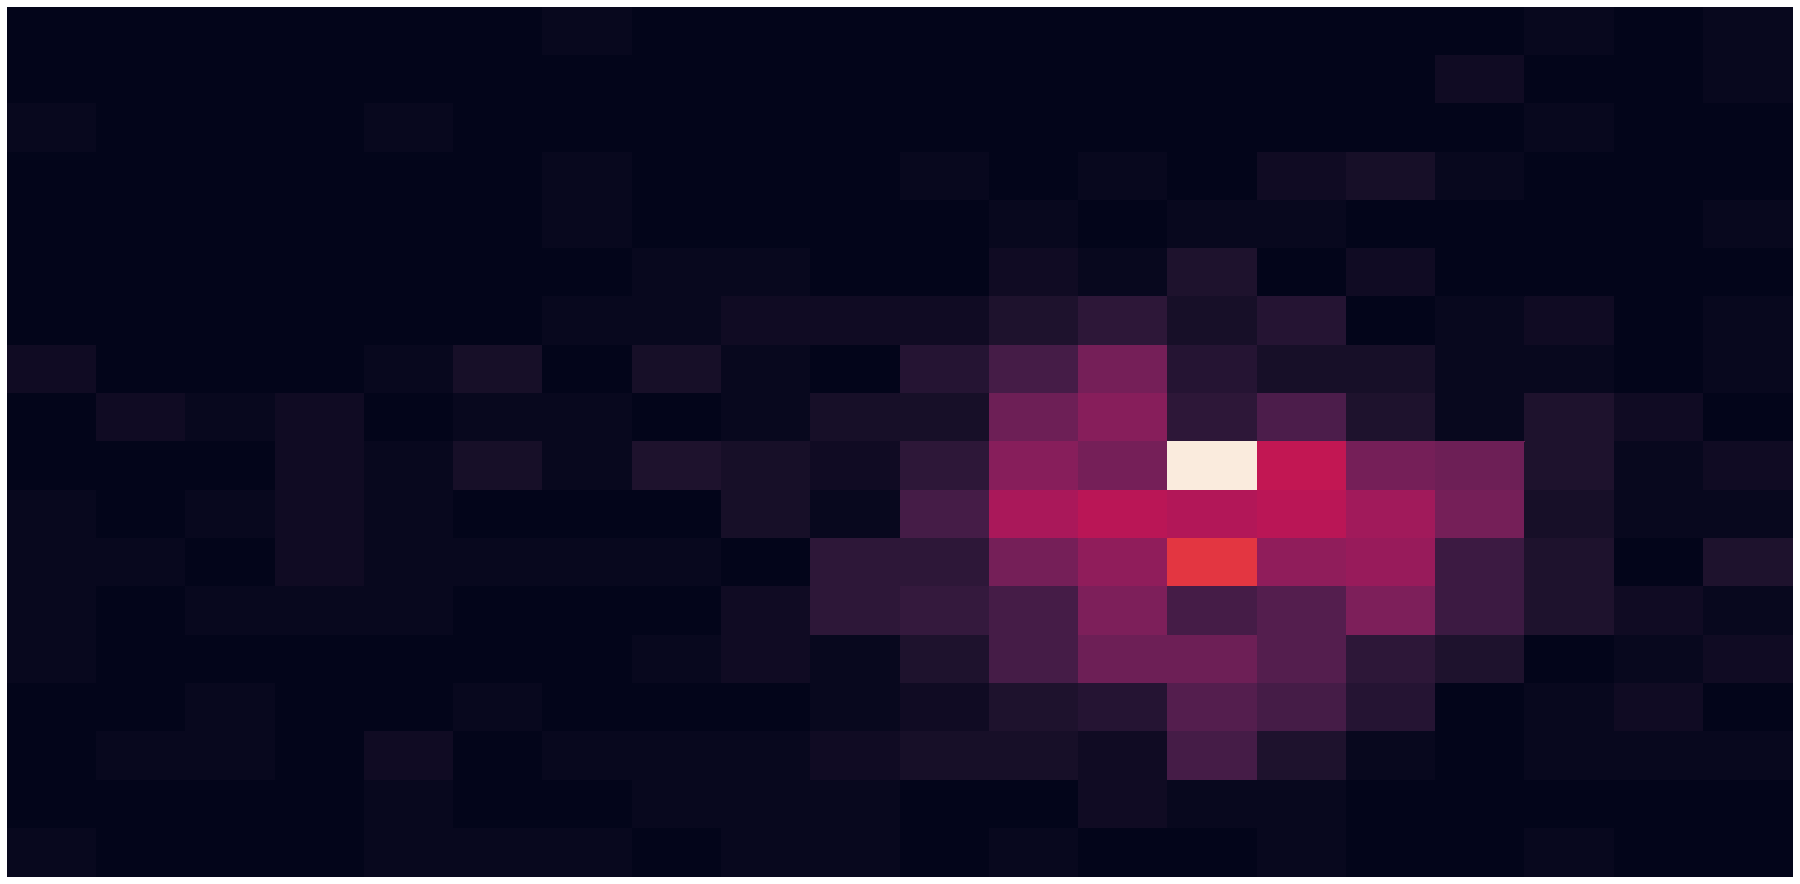

In [332]:
#合成用ヒートマップ作成
hm_name = "hm_"+file+".jpg" #<- dirをつける
plt.figure(figsize=(32,16)) 
sns.heatmap(lst_2d,vmin=0, vmax=50,yticklabels=False,xticklabels=False,cbar=False)
plt.savefig(hm_name )

In [168]:
#削除対象
#HM原画サイズ確認
filename = hm_name
img2 = cv2.imread(filename)
height = img2.shape[0]
width = img2.shape[1]
print('h:{}/w{}'.format(height,width))

h:1152/w2304


In [206]:
#削除対象
#余白削除
def margin_cut(file_name='./hm_7306642.jpg',output_name='./hm_7306642_edge.png'):
    filename = file_name #'./image_3453421.jpg'
    img = cv2.imread(filename)
    img2 = cv2.imread(filename)

    # Grayscale に変換
    img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2 値化
    ret, thresh = cv2.threshold(img_gs, 250, 255, cv2.THRESH_BINARY)

    # 輪郭を取得
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # i = 1 は画像全体の外枠になるのでカウントに入れない
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in range(1, len(contours)):
        # ret の中身は (x, y, w, h)
        ret = cv2.boundingRect(contours[i])
        x1.append(ret[0])
        y1.append(ret[1])
        x2.append(ret[0] + ret[2])
        y2.append(ret[1] + ret[3])

    x1_min = min(x1)
    y1_min = min(y1)
    x2_max = max(x2)
    y2_max = max(y2)

    # 枠取りをした結果を表示
    #cv2.rectangle(img, (x1_min, y1_min), (x2_max, y2_max), (0, 255, 0), 2)
    #cv2.imwrite('cropped_edge_rectangle.jpg', img)

    # ギリギリで切り出し
    crop_img = img2[y1_min:y2_max, x1_min:x2_max]
    cv2.imwrite(output_name, crop_img)


In [334]:
#HM余白削除
outfile = './hm_' + file + '_edge.jpg' # <- dirをつける
#outfile = margin_cut(hm_name,outfile)
margin_cut(hm_name,outfile)

In [243]:
#削除対象
#凡例付きヒートマップ余白削除
outfile = './hm_' + file + '_sample_edge.jpg'
margin_cut(hm_name_sample,outfile)

In [375]:
#item画像読み込み
#filename = './3453421_2048x1024.jpeg'
filename = './' + file + '_2048x1024.jpg' # <- dirをつける
try:
    img = cv2.imread(filename)
    height = img.shape[0]
except  AttributeError:
    print('file not found. {}'.format(filename))
#cv2.imshow("color",img)
#cv2.imshow("gray",img2)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

file not found. ./7520862-_2048x1024.jpg


In [371]:
#削除対象
#item画像サイズ確認
height = img.shape[0]
width = img.shape[1]
print('h:{}/w{}'.format(height,width))

AttributeError: 'NoneType' object has no attribute 'shape'

In [337]:
#余白除去後HM読み込み
filename = './hm_' + file + '_edge.jpg' # <- dirをつける
try: 
    img2 = cv2.imread(filename)
    height = img2.shape[0]
except  AttributeError:
    print('file not found.')

In [338]:
#削除対象
height = img2.shape[0]
width = img2.shape[1]
print('h:{}/w{}'.format(height,width))

h:872/w1788


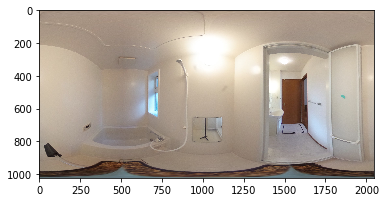

In [339]:
#削除対象
#画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

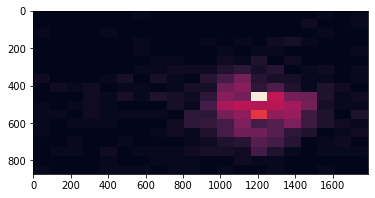

In [340]:
#削除対象
#filename = 'hm_7306642_edge.jpg'
#img2 = cv2.imread(filename)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

In [341]:
#削除対象
height = img2.shape[0]
width = img2.shape[1]
print(img2.shape)

(872, 1788, 3)


In [342]:
#サイズ調整
img2_1 = cv2.resize(img2 , (int(width*(2048.5/width)), int(height*(1024/height))))
print(img2_1.shape)
cv2.imwrite('hm_edge.jpg', img2_1)

(1024, 2048, 3)


True

In [181]:
#img2 = Image.open('hm_edge.jpg')

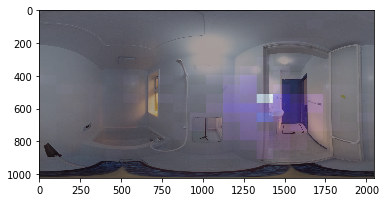

In [343]:
#画像合成
blended = cv2.addWeighted(src1=img,alpha=0.6,src2=img2_1,beta=0.4,gamma=0.3)
plt.imshow(blended)

In [344]:
#合成後画像保存
cv2.imwrite('blended_test_' + file + '.jpg', blended) # <- dirをつける

True

In [345]:
#凡例切り出し準備
im = Image.open(hm_name_sample)

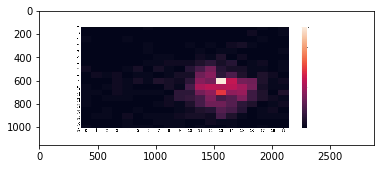

In [346]:
plt.imshow(im)

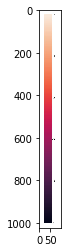

In [347]:
#凡例切り出し&resize
im_crop = im.crop((2230,120,2350,1030))
im_crop_rsize = im_crop.resize((100,1024))   
plt.imshow(im_crop_rsize)
im_crop_rsize.save('./colorbar_crop.jpg', quality=100) # <- dirをつける

In [348]:
#ブランク画像作成
height = 1024
width = 2200
blank = np.zeros((height, width, 3))
blank += 255 #←全ゼロデータに255を足してホワイトにする
 
cv2.imwrite('blank.jpg',blank) # <- dirをつける

True

In [349]:
#凡例付きヒートマップ作成
img0 = cv2.imread('./blank.jpg') # <- dirをつける
img1 = cv2.imread('./blended_test_' + file + '.jpg') # <- dirをつける
img2 = cv2.imread('./colorbar_crop.jpg') # <- dirをつける

img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

base_img = img0


In [350]:
#ヒートマップ画像貼り付け基準点設定
x_offset=0
y_offset=0

In [351]:
#ヒートマップ画像合成
base_img[y_offset:y_offset+img1.shape[0], x_offset:x_offset+img1.shape[1]] = img1

In [352]:
#凡例画像貼り付け基準点設定
x_offset=2050
y_offset=0

In [353]:
#凡例画像合成
base_img[y_offset:y_offset+img2.shape[0], x_offset:x_offset+img2.shape[1]] = img2

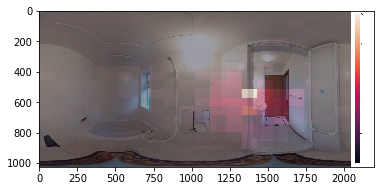

In [354]:
#削除対象
plt.imshow(base_img)

In [355]:
base_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)
strdate = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S') # 制作日
cv2.imwrite('./blended_test_ver2_' + file + strdate + '.jpg',base_img) # <- dirをつける

True

In [383]:
import datetime
datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')

'2020-04-09T11:06:49'